In [102]:
#https://www.sejuku.net/blog/61017
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score,KFold
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import train_test_split
import lightgbm as lgb
#正規化・標準化ライブラリ
from sklearn.preprocessing import StandardScaler
#scipyの統計関数群のAPI
from scipy import stats
from sklearn.metrics import mean_squared_error
#警告制御
from scipy import stats
from scipy.stats import norm, skew #for some statistics
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [63]:
df_train = pd.read_csv('input/train.csv')
df_test = pd.read_csv('input/test.csv')

In [64]:
train_ID = df_train['Id']
test_ID = df_test['Id']

In [80]:
df_train.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [81]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [82]:
#要約統計量
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

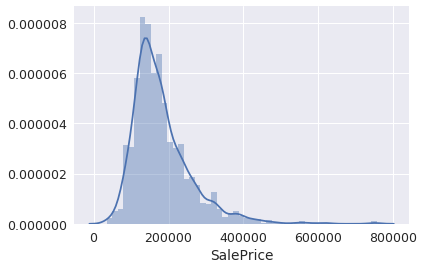

In [83]:
#ヒストグラムを描画
sns.distplot(df_train['SalePrice'])

# 歪度と尖度
歪度:分布が正規分布からどれだけ歪んでいるかを表す統計量
左右の対称性を示す指標
右袖が長い、左に偏った分布の時には正の値
左袖が長い、右に偏った分布の時に負の値

尖度:分布が正規分布からどれだけ尖っているかを表す統計量で、山の尖り度と裾の広がり度を示す
分布より尖った分布の時は正の値を、正規分布より扁平な分布の時は負の値をとる。
正規分布の時は０になる

In [84]:
#skewness and kurtosis
#df.skewで歪度を計算
#歪度とは分布の非対称性を示す指標。値が正であると分布が右に伸びている。逆に負であると左に伸びている
print("Skewness: %f" % df_train['SalePrice'].skew())

Skewness: 1.882876


In [85]:
#df.kurtで尖度を計算
#正規分布を基準とした分布の鋭さの指標
#正規分布の尖度を０とする場合と3と定義する場合がある
#尖度よりも大きければ分布は尖っており、小さければ緩やかな分布である。
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Kurtosis: 6.536282


# 数値説明変数と目的変数

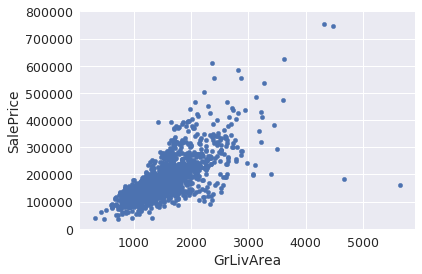

In [86]:
#scatter plot grlivarea/saleprice
var = 'GrLivArea'
#pd.concatメソッドは二つのDFの連結.axis=1なので横方向に連結
#つまり２つのDFの紐付けは連結方向ではないラベル=indexで行われる。
#pd.concat　に入れる２つのdataframeをリスト形式で入れる
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
#plot.scatterは散布図を描画するメソッド。
#グラフの軸を調整。例えば大きすぎる範囲なので、特定範囲を見せたいとき
#ylimはy軸の範囲の指定
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));


In [87]:
 #目的変数と説明変数の散布図を関数化

def scatter(var):
    data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
    data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

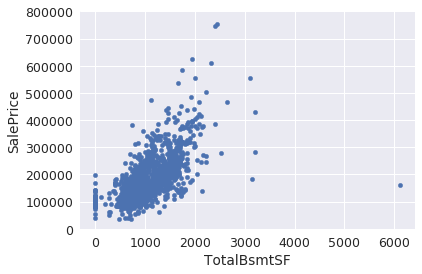

In [88]:
scatter('TotalBsmtSF')

# カテゴリの特徴との関係


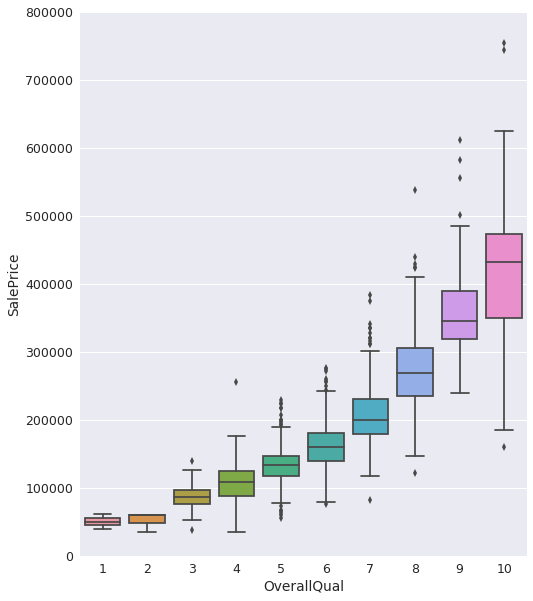

In [89]:
#box plot overallqual/saleprice
var = 'OverallQual'
#カラムが'SalePrice'とvarのデータフレームを横方向に連結
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
#subplots()メソッドはFigure,AxesSubplotオブジェクトをタプルで返す
#matplotlibでグラフを作成する方法として、対話形式オブジェクト思考形式の２通りがある。
#どちらの表記でも同じグラフを区政できるが、オブジェクト指向形式で覚えておくといい
#複数のグラフを対話形式で記載すると操作対象がわかりにくくなる。
#オブジェクト指向形式で覚えておくと、複雑な作図処理にも応用がきく。

f, ax = plt.subplots(figsize=(8, 10))
#snsのboxplotメソッドは箱ひげ図をプロットする。
#x軸にvar,y軸に"SalePrice"カラムを設定。dataはデータフレームを示す
fig = sns.boxplot(x=var, y="SalePrice", data=data)
#plt.axisで軸の範囲（最大最小）などを決める
fig.axis(ymin=0, ymax=800000);

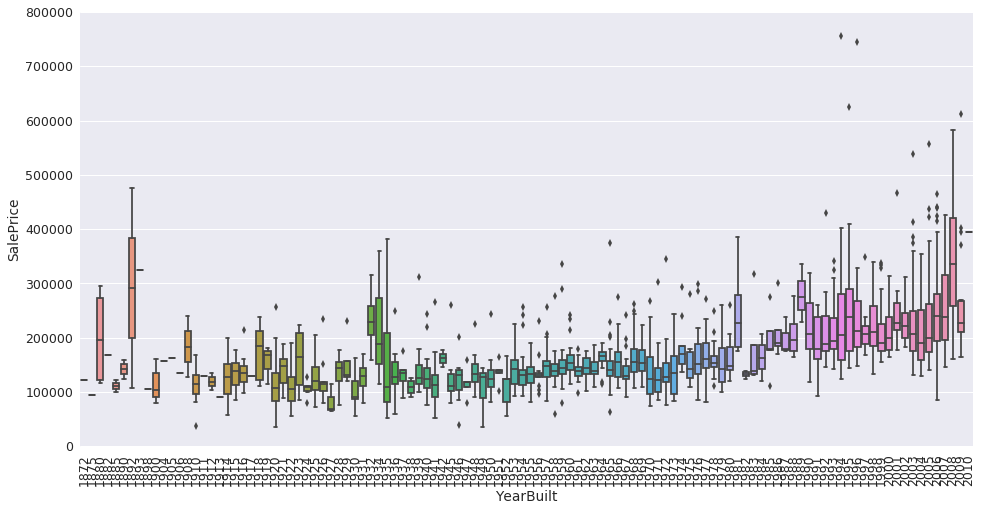

In [90]:
var = 'YearBuilt'
data=pd.concat([df_train['SalePrice'],df_train[var]],axis=1)
fig,ax = plt.subplots(figsize=(16,8))
fig = sns.boxplot(x=var,y='SalePrice',data=data)
fig.axis(ylim=0,ymax=800000)
plt.xticks(rotation=90);#←セミコロンをつけないと配列が表示される

新しい建物にお金を使う傾向がある
'GrLivArea'と 'TotalBsmtSF'は 'SalePrice'と線形関係にあるようです。両方の関係は正の値をとります。つまり、一方の変数が増加すると他方の変数も増加します。 'TotalBsmtSF'の場合、線形関係の傾きが特に高いことがわかります。
'OverallQual'と 'YearBuilt'も 'SalePrice'と関連しているようです。 'OverallQual'のケースでは、販売価格が全体の品質とともにどのように上昇するかをボックスプロットで示しています。

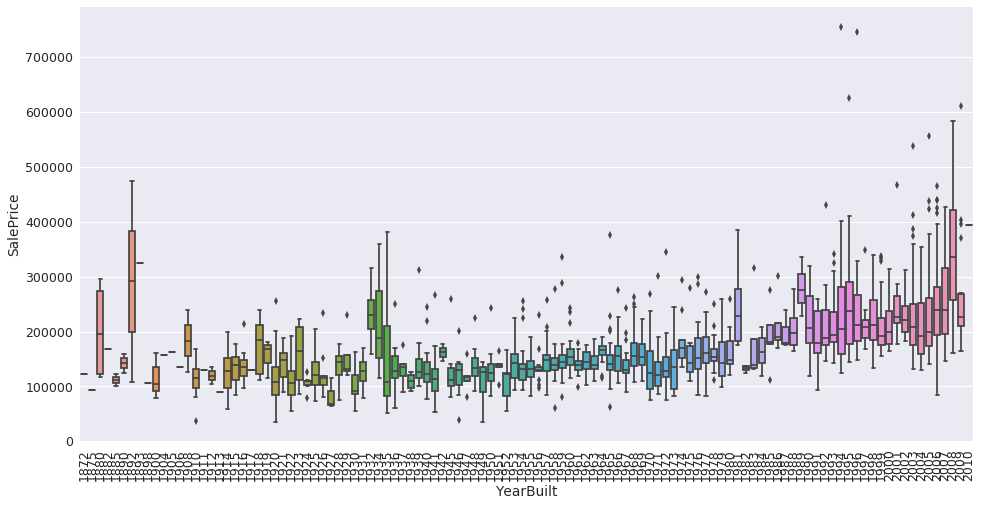

In [91]:
var = 'YearBuilt'
data=pd.concat([df_train['SalePrice'],df_train[var]],axis=1)
fig,ax = plt.subplots(figsize=(16,8))
fig.axis = sns.boxplot(x=var,y='SalePrice',data=data)
plt.xticks(rotation=90);

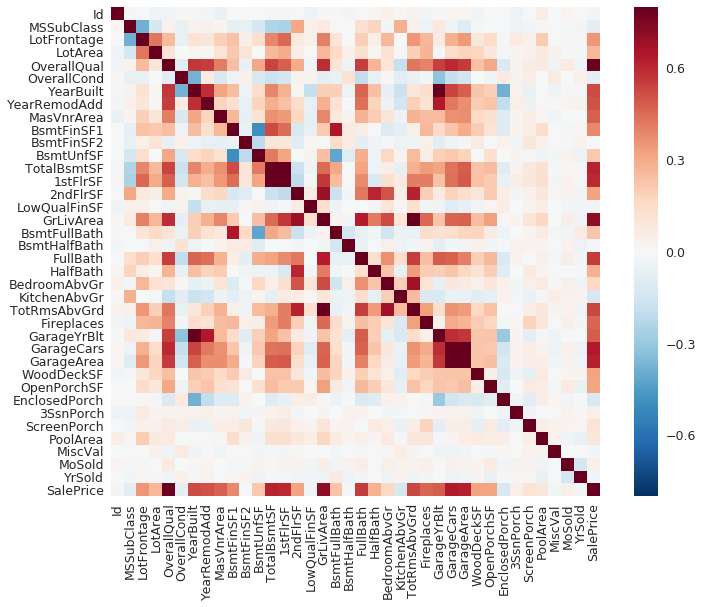

In [92]:
#相関行列の作成
#Numpyのcorroefかpandasのcorr()で相関係数の算出
#Numpyのcorrcoefはデフォルトでは行間の相関係数を計算する
#pandasのデータフレームのcorr()メソッドは列間の相関を計算する。
corrmat = df_train.corr()
fig,ax = plt.subplots(figsize=(12,9))
#corrmatはheatmapの引数のdataに当たる
sns.heatmap(corrmat, vmax=.8, square=True);

多重線形性の発生を確認できる

In [93]:
#目的変数と相関の高い上位１０の独立変数をプロット
k=10
#
cols = corrmat.nlargest(k, 'SalePrice').index

In [96]:
cols

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt'],
      dtype='object')

In [94]:
# cm = np.corrcoef(df_train[cols].values.T)cols

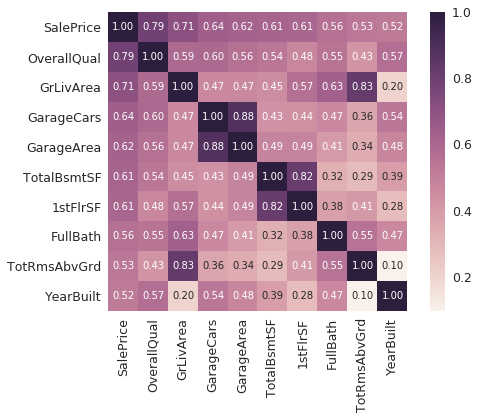

In [95]:
cm = df_train[cols].corr()
sns.set(font_scale=1.25)
hm= sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

# 重要度が高かったデータとの相関が高いデータを確認

- GrLivArea：上級（地上）のリビングエリア平方フィート
- LotArea：ロットサイズ（平方フィート）
- TotalBsmtSF：地下1階の総平方フィート
- YearBuilt：建設日

In [98]:
GA_corr= corrmat['GrLivArea'].sort_values()
GA_corr = GA_corr.dropna()

Text(0.5,1,'GA_corr')

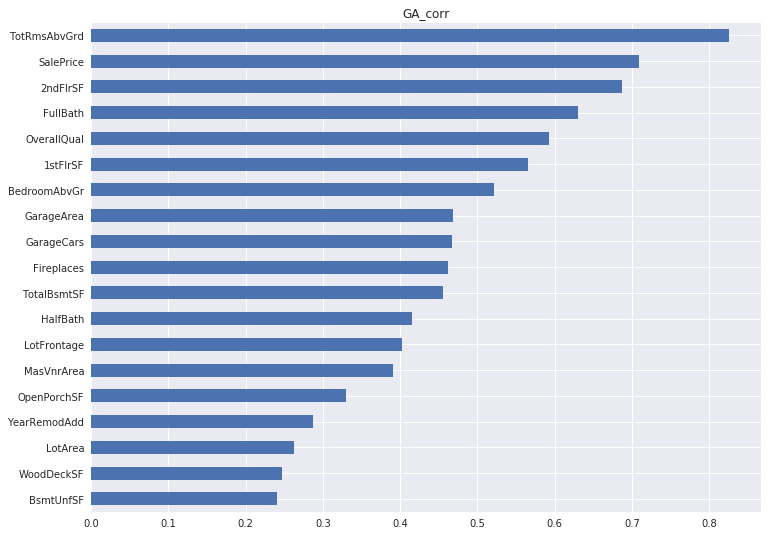

In [106]:
fig,ax = plt.subplots(figsize=(12,9))
abs(GA_corr).sort_values()[-20:-1].plot.barh()
plt.title("GA_corr")

In [109]:
LA_corr= corrmat['LotArea'].sort_values()
LA_corr = LA_corr.dropna()

Text(0.5,1,'LA_corr')

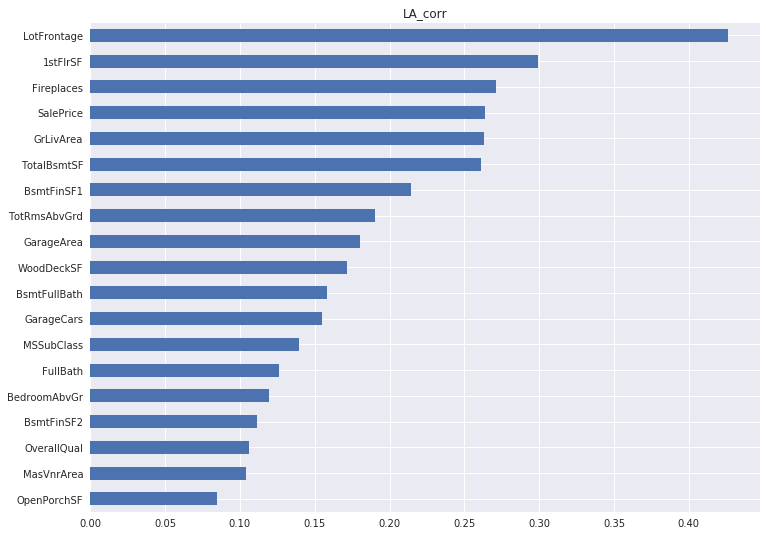

In [110]:
fig,ax = plt.subplots(figsize=(12,9))
abs(LA_corr).sort_values()[-20:-1].plot.barh()
plt.title("LA_corr")

In [112]:
TbSF_corr= corrmat['TotalBsmtSF'].sort_values()
TbSF_corr=TbSF_corr.dropna()

Text(0.5,1,'TbSF_corr')

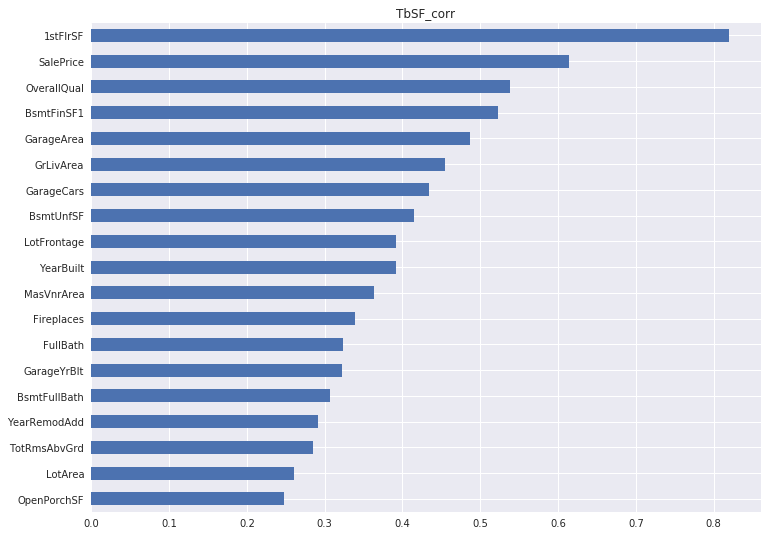

In [113]:
fig,ax = plt.subplots(figsize=(12,9))
abs(TbSF_corr).sort_values()[-20:-1].plot.barh()
plt.title("TbSF_corr")

'GarageCars'と 'GarageArea'はガレージに収まる車の数はガレージの面積の結果なのでこの２つを区分する必要がない。
TotalBsmtSFと'1stFloor'も同様である。

In [114]:
YearBuilt_corr= corrmat['YearBuilt'].sort_values()
YearBuilt_corr=YearBuilt_corr.dropna()

Text(0.5,1,'YearBuilt_corr')

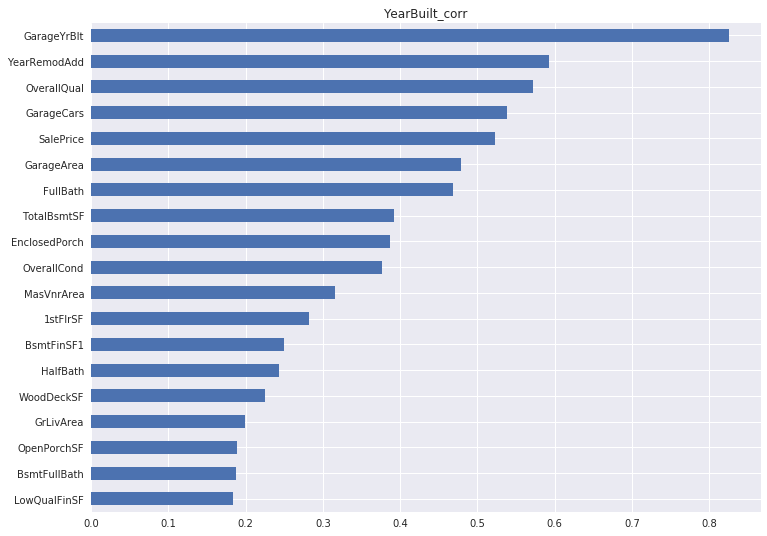

In [115]:
fig,ax = plt.subplots(figsize=(12,9))
abs(YearBuilt_corr).sort_values()[-20:-1].plot.barh()
plt.title("YearBuilt_corr")

In [ ]:
#　車の台数* (-築年数)


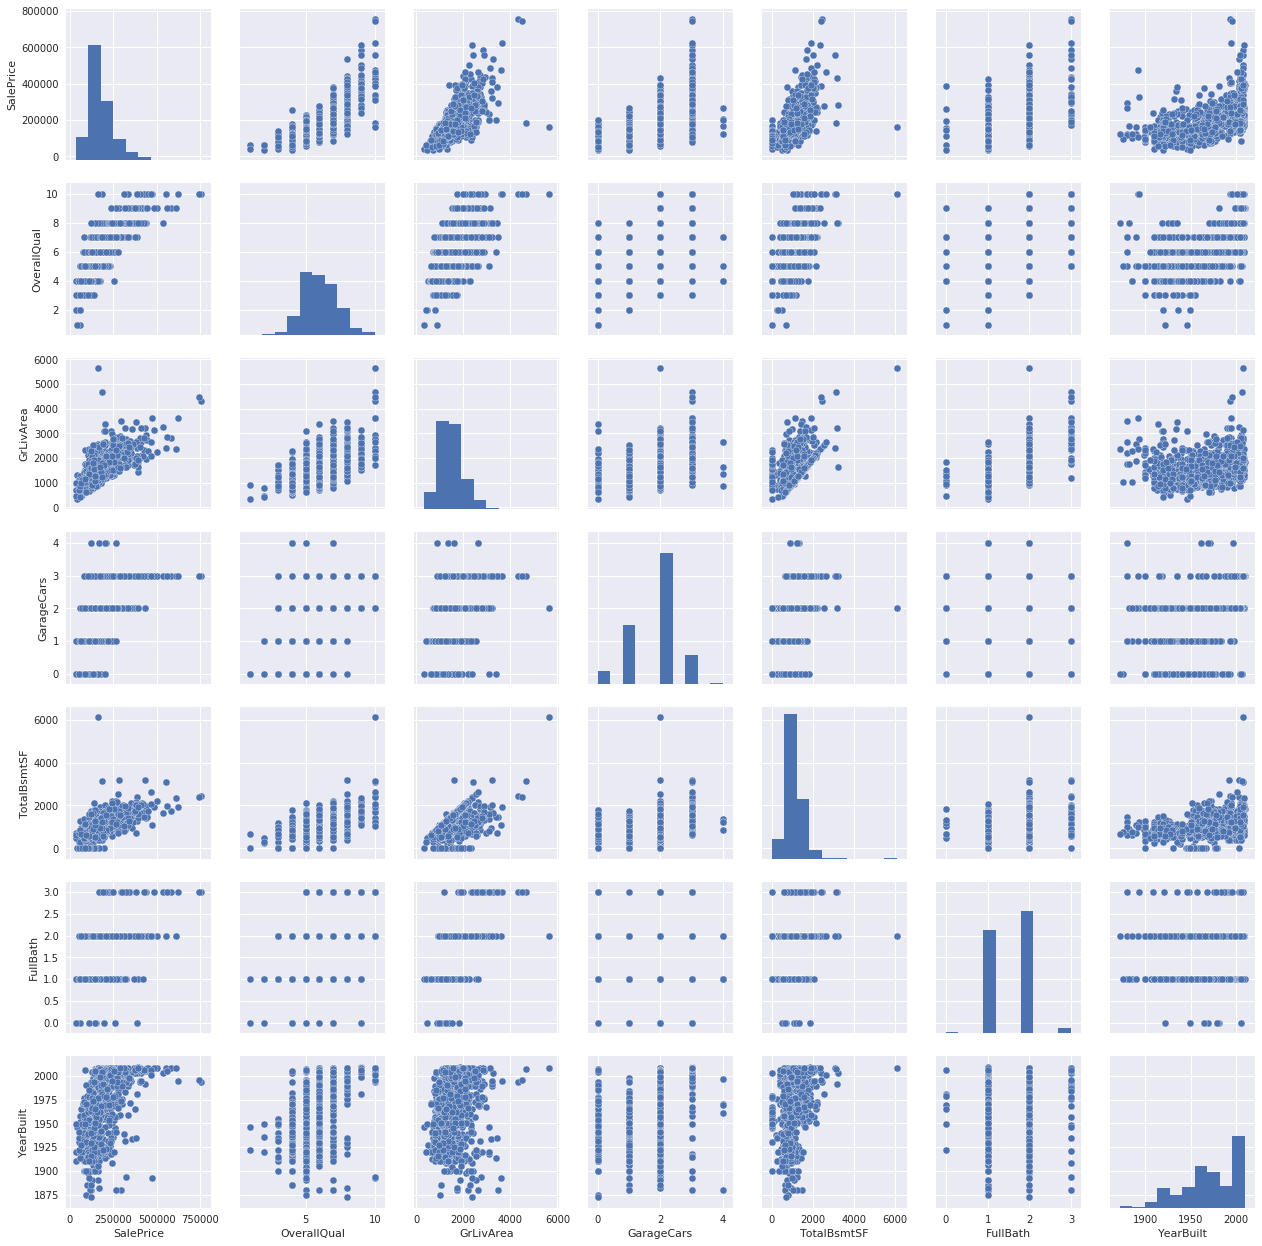

In [36]:
#目的変数と相関変数の散布図
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols],size=2.5)


In [37]:
#欠損値の合計
df_train.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageCars          0
GarageArea          0
GarageQual         81
GarageCond         81
PavedDrive

In [38]:
#全てのデータ数の合計
df_train.isnull().count()

Id               1460
MSSubClass       1460
MSZoning         1460
LotFrontage      1460
LotArea          1460
Street           1460
Alley            1460
LotShape         1460
LandContour      1460
Utilities        1460
LotConfig        1460
LandSlope        1460
Neighborhood     1460
Condition1       1460
Condition2       1460
BldgType         1460
HouseStyle       1460
OverallQual      1460
OverallCond      1460
YearBuilt        1460
YearRemodAdd     1460
RoofStyle        1460
RoofMatl         1460
Exterior1st      1460
Exterior2nd      1460
MasVnrType       1460
MasVnrArea       1460
ExterQual        1460
ExterCond        1460
Foundation       1460
                 ... 
BedroomAbvGr     1460
KitchenAbvGr     1460
KitchenQual      1460
TotRmsAbvGrd     1460
Functional       1460
Fireplaces       1460
FireplaceQu      1460
GarageType       1460
GarageYrBlt      1460
GarageFinish     1460
GarageCars       1460
GarageArea       1460
GarageQual       1460
GarageCond       1460
PavedDrive

# 数値特徴量の分布の偏りを確認

In [43]:
numeric_feats = df_train.dtypes[df_train.dtypes != "object"].index

In [44]:
# Check the skew of all numerical features
skewed_feats = df_train[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(15)


Skew in numerical features: 



,Skew
MiscVal,24.451640
PoolArea,14.813135
LotArea,12.195142
3SsnPorch,10.293752
LowQualFinSF,9.002080
KitchenAbvGr,4.483784
BsmtFinSF2,4.250888
ScreenPorch,4.117977
BsmtHalfBath,4.099186
EnclosedPorch,3.086696


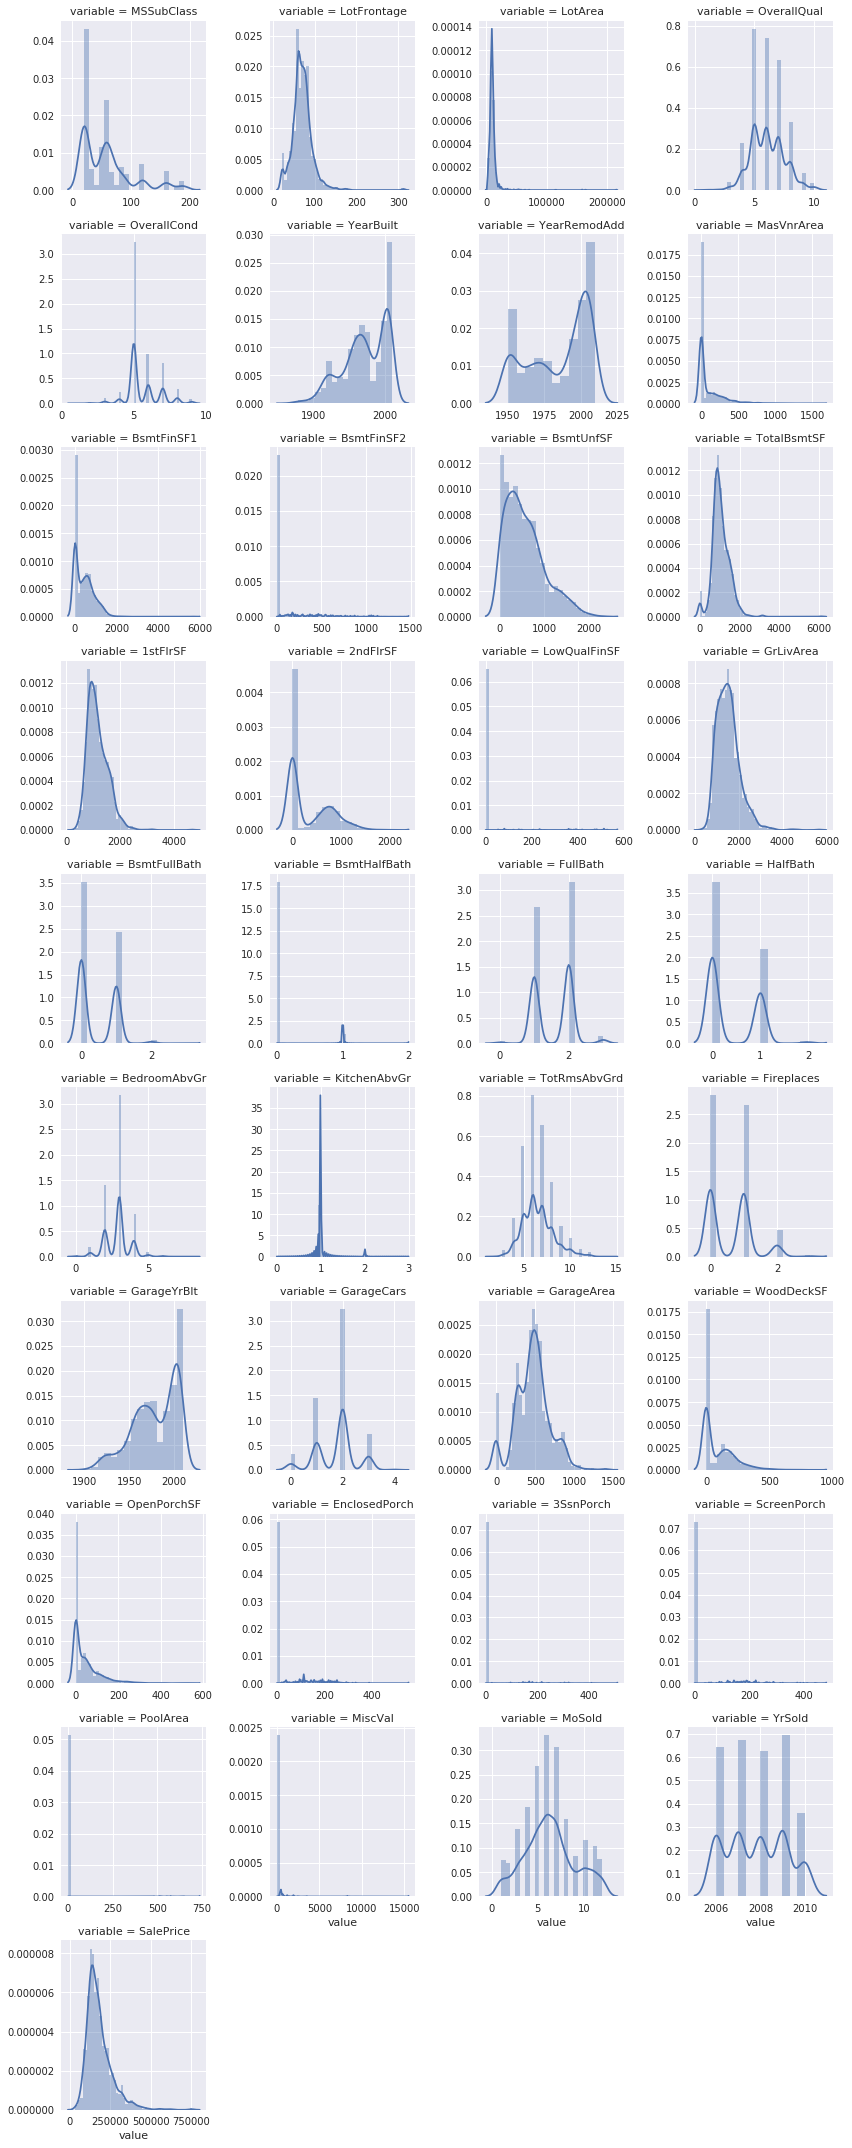

In [46]:
num = [f for f in df_train.columns if df_train.dtypes[f] != 'object']
num.remove('Id')
nd = pd.melt(df_train, value_vars = num)
n1 = sns.FacetGrid (nd, col='variable', col_wrap=4, sharex=False, sharey = False)
n1 = n1.map(sns.distplot, 'value')
n1

大半の特徴量が右に裾

# データの四分位数と外れ値を確認


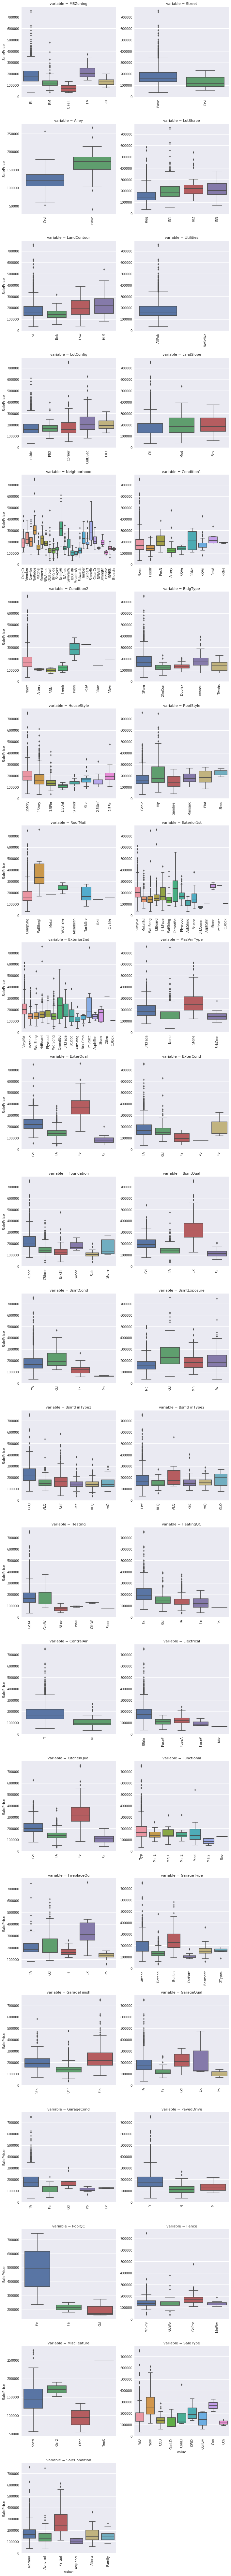

In [51]:
def boxplot(x,y,**kwargs):
            sns.boxplot(x=x,y=y)
            x = plt.xticks(rotation=90)

cat = [f for f in df_train.columns if df_train.dtypes[f] == 'object']

p = pd.melt(df_train, id_vars='SalePrice', value_vars=cat)
g = sns.FacetGrid (p, col='variable', col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, 'value','SalePrice')
g


# 外れ値が目立つ

In [45]:
cat_feats = [col for col in list(df_train.columns) if df_train[col].dtype == 'object']

In [59]:
X = df_train.drop('SalePrice',axis=1)
y = df_train['SalePrice']

# 前処理

# LightGBMはobject型で学習できないので、順序変数などは考慮せず、カテゴリ変数をファクトライズする

# カテゴリ変数を取得して、factorizeする関数を定義

In [94]:
def _get_categorical_features(df):
    feats = [col for col in list(df.columns) if df[col].dtype == 'object']
    return feats
def _factorize_categoricals(df, cats):
    for col in cats:
        df[col], _ = pd.factorize(df[col])
    return df 

# カテゴリ変数を取得

In [95]:
data_cats = _get_categorical_features(X)

# カテゴリ変数をファクトライズ

In [97]:
data = _factorize_categoricals(X, data_cats)
data = _factorize_categoricals(df_test, data_cats)

In [52]:
def _factorize_categoricals(df, cat_feats):
    for col in cat_feats:
        df[col], _ = pd.factorize(df[col])
    return df

In [53]:
feats = [f for f in df_train.columns if f not in ['ID']]

In [54]:
df_train = _factorize_categoricals(df_train,cat_feats)
df_test = _factorize_categoricals(df_test,cat_feats)

# 学習の準備

In [71]:
X = df_train.drop('SalePrice',axis=1)
y = df_train['SalePrice']

# 目的変数の分布が右に裾で、対数変換しなければならないことと,提出時の評価に目的変数を対数変換しているのでそれに従う

In [101]:
y  =y.apply(np.log)

# クロスバリデーションを作成

In [102]:
n_folds = 5
y_train = df_train.SalePrice.values
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(df_train.values)
    rmse= np.sqrt(-cross_val_score(model,X, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

#  Light GBM

In [76]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)

In [78]:
lgb_train = lgb.Dataset(data=x_train, label=y_train)
lgb_eval = lgb.Dataset(data=x_test, label=y_test)

In [116]:
#値は適当
params = {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'regression', 'metric': {'l2'}, 
          'learning_rate': 0.01, 'num_leaves': 48, 'num_iteration': 5000, 'verbose': 0 ,
          'colsample_bytree':.8, 'subsample':.9, 'max_depth':7, 'reg_alpha':.1, 'reg_lambda':.1, 
          'min_split_gain':.01, 'min_child_weight':1}

In [80]:
# # 上記のパラメータでモデルを学習〜交差検証までする
# cv_results = lgb.cv(params, lgb_train, nfold=10)
# cv_logloss = cv_results['multi_logloss-mean']
# round_n = np.arange(len(cv_logloss))

# plt.xlabel('round')
# plt.ylabel('logloss')
# plt.plot(round_n, cv_logloss)
# plt.show()

# 学習

In [108]:
# model = lgb.train(params, lgb_train, valid_sets=lgb_eval, early_stopping_rounds=150, verbose_eval=200)

In [110]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
score = rmsle_cv(model_lgb)

In [111]:
model_lgb.fit(X,y)

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
       boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.2319, feature_fraction_seed=9,
       importance_type='split', learning_rate=0.05, max_bin=55,
       max_depth=-1, min_child_samples=20, min_child_weight=0.001,
       min_data_in_leaf=6, min_split_gain=0.0, min_sum_hessian_in_leaf=11,
       n_estimators=720, n_jobs=-1, num_leaves=5, objective='regression',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [112]:
model_lgb.predict(df_test.values)

array([ 2.50301746,  2.48778843,  2.50344908, ...,  2.5038899 ,
        2.50907035,  2.46891879])

In [82]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1246 (0.0098)



In [113]:
sub_pred = model.predict(df_test.values)

In [114]:
# model_lgb.fit(X,y)

In [115]:
# model_lgb.predict(df_test.values)

In [116]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = sub_pred 
sub.to_csv('submission3.csv',index=False)

In [117]:
type(model_lgb)

lightgbm.sklearn.LGBMRegressor

 # 重要度の可視化

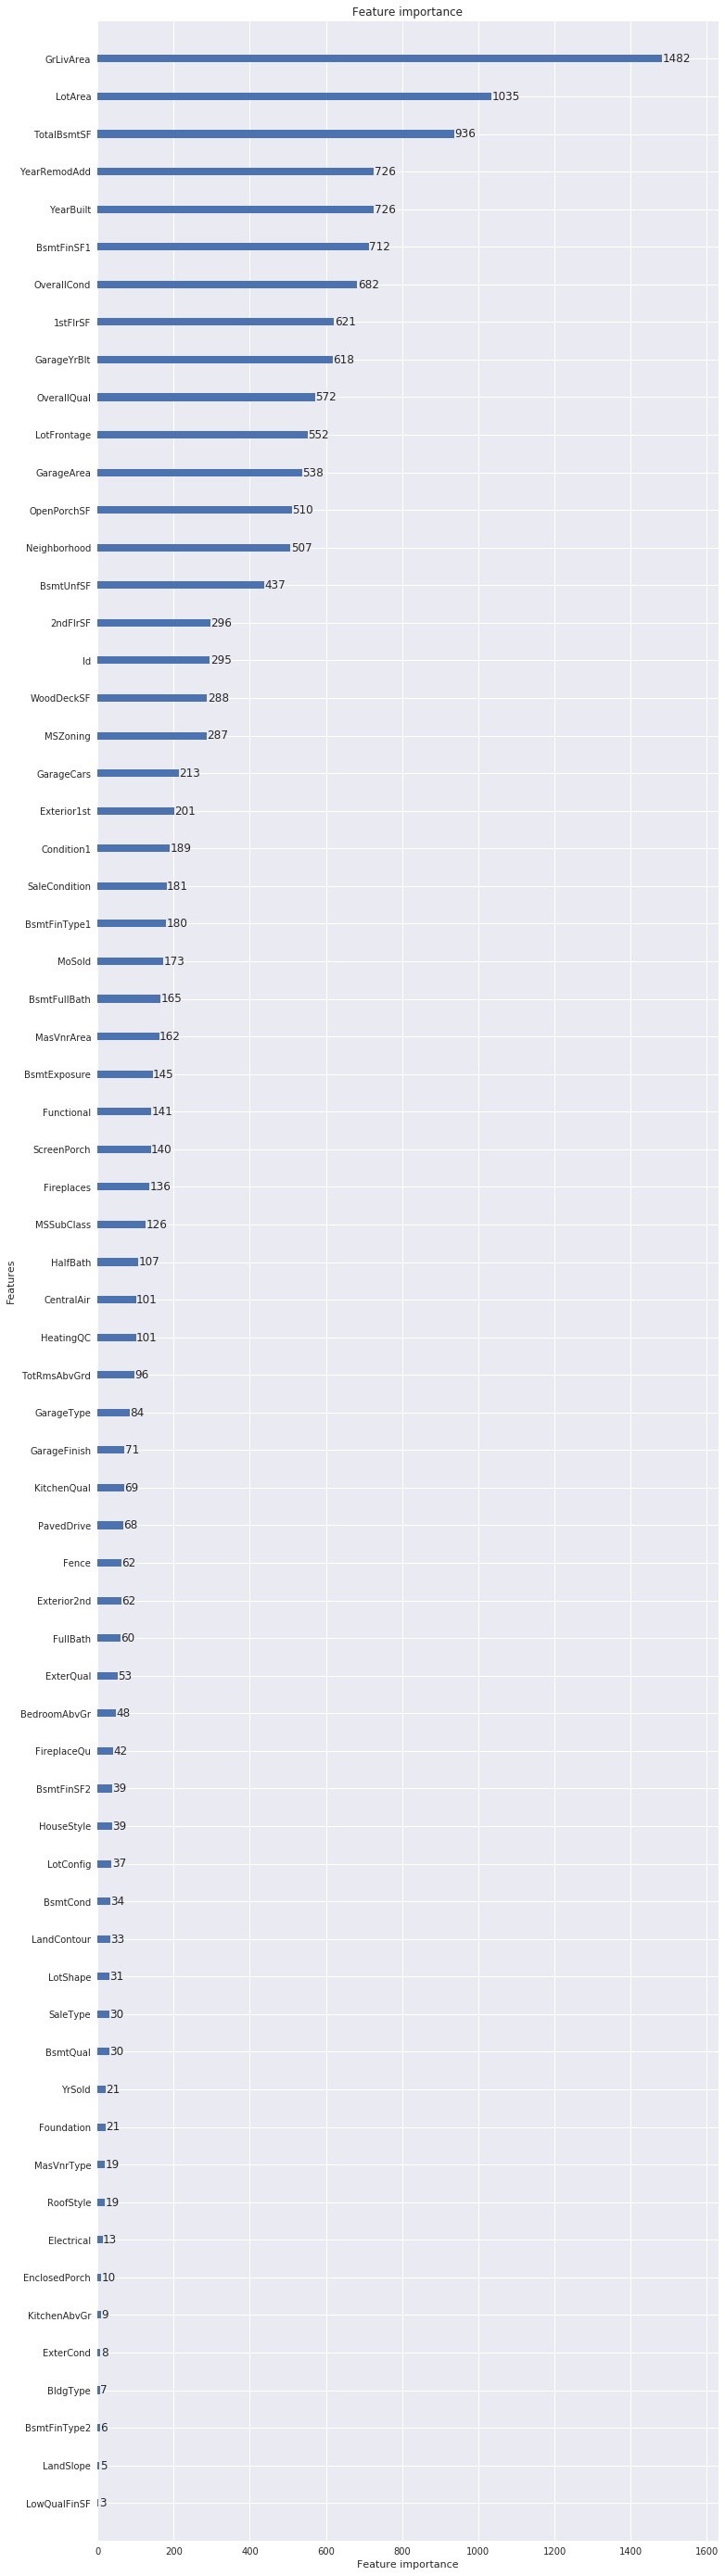

In [118]:
lgb.plot_importance(model, figsize=(12, 50));